In [11]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

from core.dataset import MachoDataset
from core.trainer import PredictionTrainer, ClassificationTrainer
from core.model import ClassificationModel

### Data setup

In [2]:
data_root = '/home/mrizhko/AML/AstroML/data/macho/'
weights_path = 'weights/model.ckpt'
window_length = 200
prediction_length = 20

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
train_dataset = MachoDataset(data_root, prediction_length, mode='train')
val_dataset = MachoDataset(data_root, prediction_length, mode='val')
test_dataset = MachoDataset(data_root, prediction_length, mode='test')

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

### Train prediction model

In [37]:
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    context_length=window_length - prediction_length - 7,  # 7 is max(lags) for default lags
    num_time_features=1,
    encoder_layers=2,
    decoder_layers=2,
    d_model=64,
)

In [38]:
model = TimeSeriesTransformerForPrediction(config)
model = model.to(device)

In [39]:
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

In [40]:
prediction_trainer = PredictionTrainer(model=model, optimizer=optimizer, device=device)

In [41]:
prediction_trainer.train(train_dataloader, val_dataloader, epochs=20)

Epoch 0: Train Loss 1.6141 Val Loss 1.4726
Epoch 1: Train Loss 1.4761 Val Loss 1.4228
Epoch 2: Train Loss 1.437 Val Loss 1.3871
Epoch 3: Train Loss 1.4152 Val Loss 1.3864
Epoch 4: Train Loss 1.3994 Val Loss 1.3647
Epoch 5: Train Loss 1.3831 Val Loss 1.3433
Epoch 6: Train Loss 1.3784 Val Loss 1.3359
Epoch 7: Train Loss 1.3667 Val Loss 1.3334
Epoch 8: Train Loss 1.357 Val Loss 1.3292
Epoch 9: Train Loss 1.3515 Val Loss 1.3101
Epoch 10: Train Loss 1.345 Val Loss 1.303
Epoch 11: Train Loss 1.3328 Val Loss 1.2966
Epoch 12: Train Loss 1.3404 Val Loss 1.2885
Epoch 13: Train Loss 1.321 Val Loss 1.2835
Epoch 14: Train Loss 1.3192 Val Loss 1.2918
Epoch 15: Train Loss 1.3171 Val Loss 1.2864
Epoch 16: Train Loss 1.311 Val Loss 1.2894
Epoch 17: Train Loss 1.3057 Val Loss 1.2847
Epoch 18: Train Loss 1.3083 Val Loss 1.2809
Epoch 19: Train Loss 1.3112 Val Loss 1.2664


In [43]:
prediction_trainer.model.save_pretrained(weights_path)

### Evaluate the pretrained model

In [6]:
model = TimeSeriesTransformerForPrediction.from_pretrained(weights_path)
model = model.to(device)

In [7]:
prediction_trainer = PredictionTrainer(model=model, optimizer=None, device=device)

In [8]:
val_dataloader = DataLoader(val_dataset, batch_size=124, shuffle=False)

In [9]:
prediction_trainer.evaluate(val_dataloader, val_dataset)

100%|█████████████████████████████████████| 16028/16028 [06:27<00:00, 41.40it/s]

MASE: 0.8835637644970156 sMAPE: 0.8496397286677474


### Classification training

In [12]:
cl_model = ClassificationModel(pretrained_model_path=weights_path, device=device)
cl_optimizer = AdamW(cl_model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)
cl_criterion = nn.CrossEntropyLoss()

In [13]:
cl_trainer = ClassificationTrainer(model=cl_model, optimizer=cl_optimizer, criterion=cl_criterion, device=device)

In [14]:
cl_trainer.train(train_dataloader, val_dataloader, epochs=20)

Epoch 0: Train Loss 1.27 	 Val Loss 1.0408 	                     Train Acc 0.5421 	 Val Acc 0.6186
Epoch 1: Train Loss 1.076 	 Val Loss 0.9685 	                     Train Acc 0.5974 	 Val Acc 0.6432
Epoch 2: Train Loss 1.0213 	 Val Loss 0.9385 	                     Train Acc 0.6211 	 Val Acc 0.6562
Epoch 3: Train Loss 0.9797 	 Val Loss 0.8865 	                     Train Acc 0.6414 	 Val Acc 0.6792
Epoch 4: Train Loss 0.9495 	 Val Loss 0.8672 	                     Train Acc 0.6532 	 Val Acc 0.6957
Epoch 5: Train Loss 0.9471 	 Val Loss 0.8581 	                     Train Acc 0.6537 	 Val Acc 0.6962
Epoch 6: Train Loss 0.9214 	 Val Loss 0.8444 	                     Train Acc 0.6664 	 Val Acc 0.7088
Epoch 7: Train Loss 0.9157 	 Val Loss 0.8263 	                     Train Acc 0.6695 	 Val Acc 0.7125
Epoch 8: Train Loss 0.9181 	 Val Loss 0.8219 	                     Train Acc 0.6692 	 Val Acc 0.7131
Epoch 9: Train Loss 0.8828 	 Val Loss 0.7955 	                     Train Acc 0.6826 	 Val Acc 

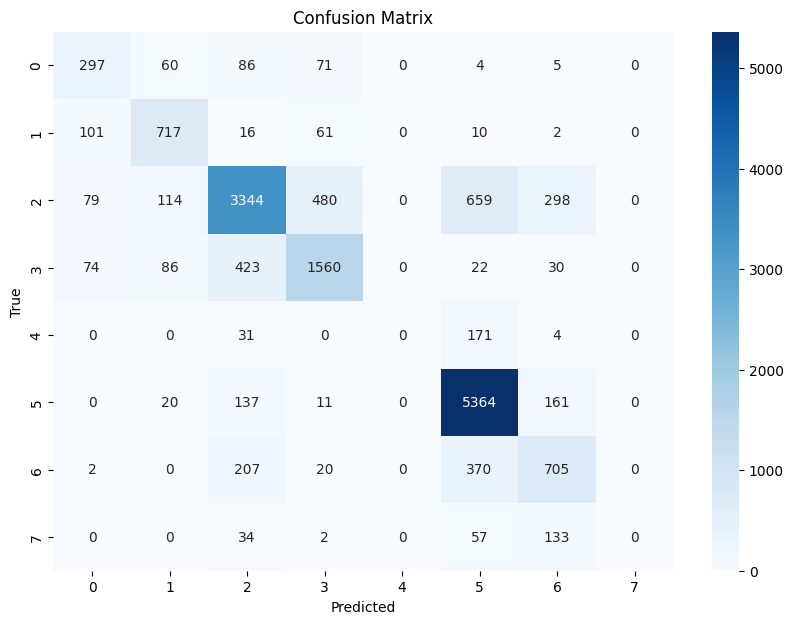

In [15]:
cl_trainer.evaluate(val_dataloader)